In [1]:
# Packages
import torch
import lightning as L
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchmetrics.functional import r2_score
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import warnings


# my model
from model.LSTM import L_LSTM_MSE as LSTM

In [2]:
# model setting
model = LSTM(input_size=14, hidden_size=28, num_layers=2, output_size=2)
window_size = 72  # determined sliding window size
torch.manual_seed = 81
epochs = 50
batch_size = 32
log_every_n_step = 10

In [6]:
# dataset
# import and modify data with pandas
warnings.filterwarnings('ignore')
directory = "data\pollution\AirPollution.csv"  # can use url
df = pd.read_csv(directory, delimiter=",")
print(df.head())
print("number of NAN in each column")
print(df.isnull().sum())
print("there are 2067 nans in pm2.5 column")

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
number of NAN in each column
No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64
there are 2067 nans in pm2.5 column


In [7]:
# modify dataframe 

# fill nan with median to maintain time series continuity
df["pm2.5"] = df.groupby(["month", "hour"])["pm2.5"].transform(
    lambda x: x.fillna(x.median())
)
# group pm2.5 by month and hour, fill NA with the mediam of each subgroup
# skipped 'day' column bc it left 6 NAN after filling

# combine to datetime and convert to unix timestamp
df["datetime"] = pd.to_datetime(
    df["year"].astype(str)
    + "-"
    + df["month"].astype(str)
    + "-"
    + df["day"].astype(str)
    + " "
    + df["hour"].astype(str)
    + ":00"
    + ":00"
)

df = df.set_index("datetime")  # set datetime as index
df["timestamp"] = df.index.map(pd.Timestamp.timestamp)  # convert to time stamp

# encode timestamp into cyclical features
day = 60 * 60 * 24
year = 365.2425 * day  # account for leap year
df["day_sin"] = np.sin(df["timestamp"] * (2 * np.pi / day))
df["day_cos"] = np.cos(df["timestamp"] * (2 * np.pi / day))
df["year_sin"] = np.sin(df["timestamp"] * (2 * np.pi / year))
df["year_cos"] = np.cos(df["timestamp"] * (2 * np.pi / year))
df.insert(0, "day_sin", df.pop("day_sin"))  # relocate columns
df.insert(1, "day_cos", df.pop("day_cos"))
df.insert(2, "year_sin", df.pop("year_sin"))
df.insert(3, "year_cos", df.pop("year_cos"))
df.drop(["No", "year", "month", "day", "hour"], axis=1, inplace=True)
# dropping unneeded columns

df = pd.get_dummies(df, columns=["cbwd"], dtype=int, drop_first=True)
# create dummy columns for 'cbwd'
df.insert(8, "cbwd_NW", df.pop("cbwd_NW"))  # relocate dummy columns
df.insert(9, "cbwd_SE", df.pop("cbwd_SE"))
df.insert(10, "cbwd_cv", df.pop("cbwd_cv"))
print(df.head())

                          day_sin   day_cos  year_sin  year_cos  pm2.5  DEWP  \
datetime                                                                       
2010-01-01 00:00:00 -4.416858e-12  1.000000  0.005161  0.999987  105.0   -21   
2010-01-01 01:00:00  2.588190e-01  0.965926  0.005878  0.999983   87.5   -21   
2010-01-01 02:00:00  5.000000e-01  0.866025  0.006594  0.999978   77.0   -21   
2010-01-01 03:00:00  7.071068e-01  0.707107  0.007311  0.999973   67.5   -21   
2010-01-01 04:00:00  8.660254e-01  0.500000  0.008028  0.999968   59.0   -20   

                     TEMP    PRES  cbwd_NW  cbwd_SE  cbwd_cv    Iws  Is  Ir  \
datetime                                                                      
2010-01-01 00:00:00 -11.0  1021.0        1        0        0   1.79   0   0   
2010-01-01 01:00:00 -12.0  1020.0        1        0        0   4.92   0   0   
2010-01-01 02:00:00 -11.0  1019.0        1        0        0   6.71   0   0   
2010-01-01 03:00:00 -14.0  1019.0        1  

In [8]:
# normalization with StandardScaler
warnings.filterwarnings('ignore')
y_scaler = StandardScaler()
y_scaler.fit(df.iloc[:, np.r_[4, 6]])
# fitting a scaler for label pm2.5 and TEMP
X_scaler = StandardScaler()
df.iloc[:, np.r_[4:8, 11:14]] = X_scaler.fit_transform(df.iloc[:, np.r_[4:8, 11:14]])
# avoid transform for cols: day/year_sin/cos + cbwd dummies + timestamp

In [9]:
# Sliding window
def slide_window(df, window_size):
    X, y, ts = [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i : (i + window_size), 0:14].values  # exclude timestamp column
        X.append(window)

        label = df.iloc[i + window_size, [4, 6]].values
        # taking column 4 pm2.5 and 6 TEMP as label
        y.append(label)

        timestamp_col = df.iloc[i + window_size, [14]].values
        ts.append(timestamp_col)
        # collect timestamp for converting to datetime in validation
    return np.array(X), np.array(y), np.array(ts)


X, y, ts = slide_window(df, window_size)

In [ ]:
# convert X, y into dataloader
input = torch.FloatTensor(X)
label = torch.FloatTensor(y)

# train test split
train_input, temp_input, train_label, temp_label = train_test_split(
    input,
    label,
    test_size=0.3,
    shuffle=False,  # no shuffle for time series
    random_state=81,
)

test_input, val_input, test_label, val_label = train_test_split(
    temp_input,
    temp_label,
    test_size=0.5,
    shuffle=False,  
    random_state=81,
)
train_dataset = TensorDataset(train_input, train_label)
test_dataset = TensorDataset(test_input, test_label)
val_dataset = TensorDataset(val_input, val_label)
# dataloader
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
# no shuffle bc time series data
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

In [47]:
# training
trainer = L.Trainer(max_epochs=epochs, log_every_n_steps=log_every_n_step)
# learning rate finder
tuner = L.pytorch.tuner.Tuner(trainer)
lr_find_results = tuner.lr_find(
    model,
    train_dataloaders=train_loader,
    min_lr=0.00001,
    max_lr=1.0,
    early_stop_threshold=None,
)
new_lr = lr_find_results.suggestion()
model.learning_rate = new_lr
print(f"lr_find() suggest {new_lr:5f} for the learning rate.")
# train to fit
trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 225.99it/s]
Learning rate set to 5.0118723362727245e-05
Restoring states from the checkpoint path at d:\Work repository\NN_test_build\.lr_find_4019bd94-57a6-47f4-9606-18b4bfbc5982.ckpt
Restored all states from the checkpoint at d:\Work repository\NN_test_build\.lr_find_4019bd94-57a6-47f4-9606-18b4bfbc5982.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 11.4 K | train
1 | fc   | Linear | 58     | train
----------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


lr_find() suggest 0.000050 for the learning rate.
Epoch 49: 100%|██████████| 958/958 [00:05<00:00, 166.19it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 958/958 [00:05<00:00, 165.96it/s, v_num=4]


In [48]:
# monitor loss by tensorboard
warnings.filterwarnings('ignore')
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 15008), started 0:34:00 ago. (Use '!kill 15008' to kill it.)

train loss settled at 0.0023

In [49]:
# testing
best_ckpt = trainer.checkpoint_callback.best_model_path
trainer.test(model, dataloaders=test_loader, ckpt_path=best_ckpt)

Restoring states from the checkpoint path at d:\Work repository\NN_test_build\lightning_logs\version_4\checkpoints\epoch=49-step=47900.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\Work repository\NN_test_build\lightning_logs\version_4\checkpoints\epoch=49-step=47900.ckpt


Testing DataLoader 0: 100%|██████████| 206/206 [00:00<00:00, 429.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.04717326536774635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.04717326536774635}]

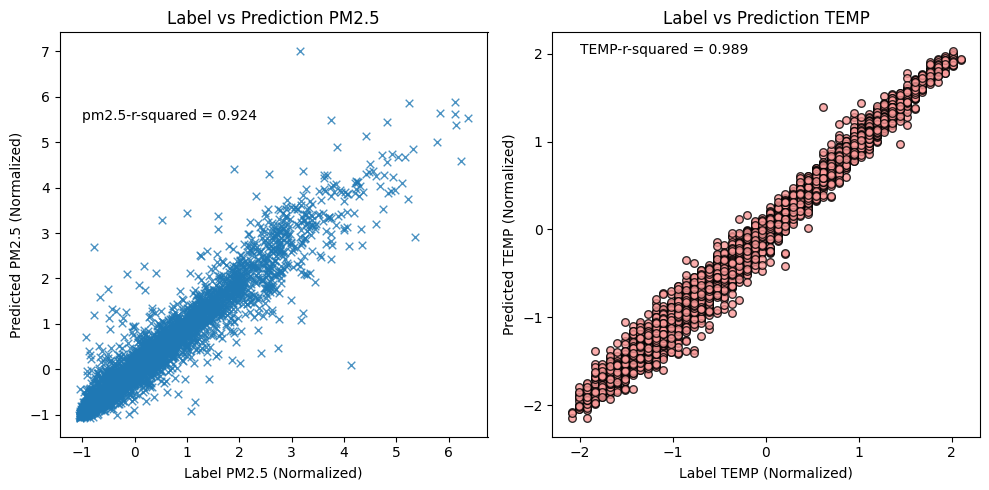

In [50]:
# r2-score and plot
test_res = model.forward(test_input).detach()

plt.figure(figsize=(10, 5))
plt.style.use("seaborn-v0_8-colorblind")
plt.subplot(1, 2, 1)
plt.scatter(
    test_label[:, 0],
    test_res[:, 0],
    marker="x",  # marker shape
    s=30,  # marker size
    c="#1f78b4",  # marker color hex code (blue)
    # edgecolors="black",  # marker edge color (not for unfilled marker)
    linewidths=1,  # axis width
    alpha=0.80,  # axis alpha
)
plt.title("Label vs Prediction PM2.5")
plt.xlabel("Label PM2.5 (Normalized)")
plt.ylabel("Predicted PM2.5 (Normalized)")
plt.annotate(
    "pm2.5-r-squared = {:.3f}".format(r2_score(test_label[:, 0], test_res[:, 0])),
    (-1, 5.5),
)
# (0,1) argument are x and y coordinate on the graph

plt.subplot(1, 2, 2)
plt.scatter(
    test_label[:, 1],
    test_res[:, 1],
    marker="o",  # marker shape
    s=30,  # marker size
    c="#fb9a99",  # marker color hex code (grapefruit)
    edgecolors="black",  # marker edge color
    linewidths=1,  # axis width
    alpha=0.80,  # axis alpha
)
plt.title("Label vs Prediction TEMP")
plt.xlabel("Label TEMP (Normalized)")
plt.ylabel("Predicted TEMP (Normalized)")
plt.annotate(
    "TEMP-r-squared = {:.3f}".format(r2_score(test_label[:, 1], test_res[:, 1])),
    (-2, 2),
)
# (0,1) argument are x and y coordinate on the graph

plt.tight_layout()
plt.show()

In [51]:
# save parameters
torch.save(model.state_dict(), "trained_parameters\l_LSTM_airpollution.pt")

In [ ]:
# prediction
loaded_model = LSTM(input_size=14, hidden_size=28, num_layers=2, output_size=2)
loaded_model.load_state_dict(torch.load("trained_parameters\l_LSTM_airpollution.pt"))

best_ckpt = trainer.checkpoint_callback.best_model_path
trainer.test(loaded_model, dataloaders=test_loader, ckpt_path=best_ckpt)

# val_output, val_label, datetime convert to df
val_output = loaded_model.forward(val_input).detach()
val_output = pd.DataFrame(val_output)
val_label = pd.DataFrame(val_label)
print(val_output.shape, val_label.shape)
timestamp = pd.DataFrame(ts[-6563:])  # select the last 6563 row from ts
print(timestamp.shape)
# conver timestamp to datetime
datetime = pd.to_datetime(timestamp[0], unit="s")

res = pd.concat([datetime, val_output, val_label], axis=1)
res.columns = ["datetime", "pm2.5_pred", "TEMP_pred", "pm2.5_label", "TEMP_label"]

# inverse scaler
res.iloc[:, np.r_[1:3]] = y_scaler.inverse_transform(res.iloc[:, np.r_[1:3]])
res.iloc[:, np.r_[3:5]] = y_scaler.inverse_transform(res.iloc[:, np.r_[3:5]])
# inverse scaler

Restoring states from the checkpoint path at d:\Work repository\NN_test_build\lightning_logs\version_4\checkpoints\epoch=49-step=47900.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\Work repository\NN_test_build\lightning_logs\version_4\checkpoints\epoch=49-step=47900.ckpt


Testing DataLoader 0: 100%|██████████| 206/206 [00:00<00:00, 429.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.04717326536774635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
(6563, 2) (6563, 2)
(6563, 1)


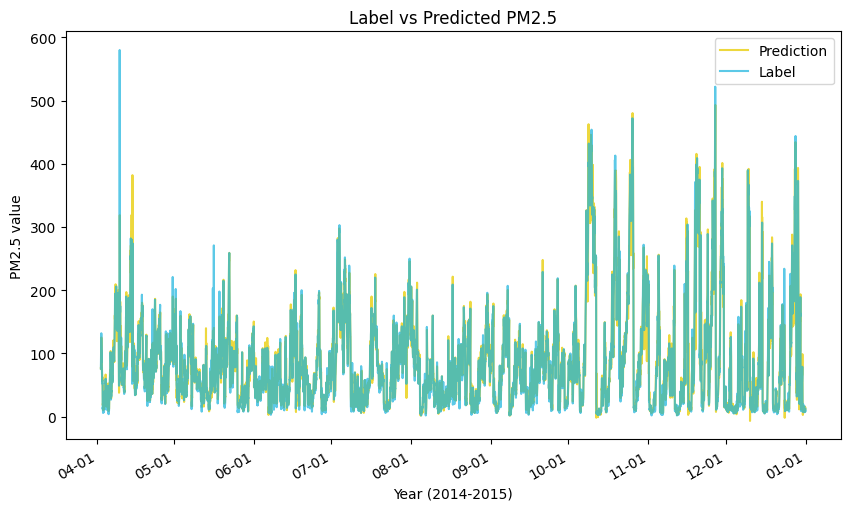

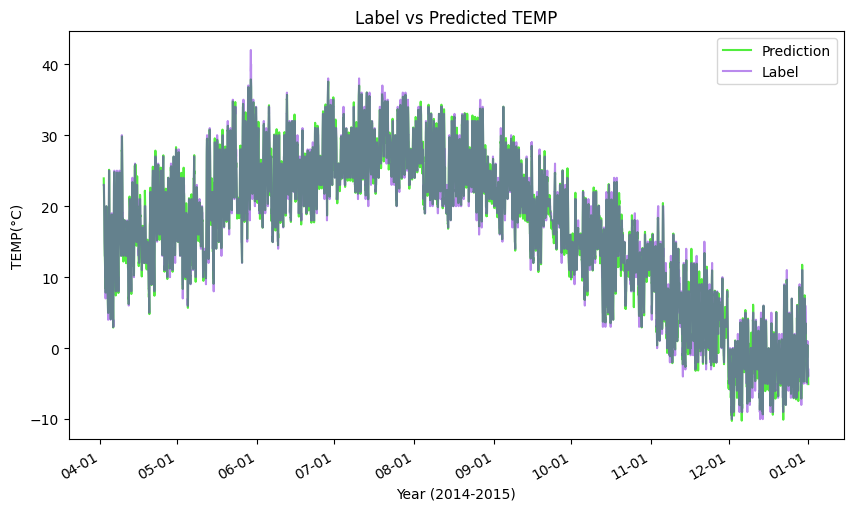

In [55]:
# scatter plots
# pm2.5 plot
plt.figure(figsize=(10, 6))
plt.style.use("seaborn-v0_8-colorblind")
# line 1
plt.plot(
    res["datetime"],
    res["pm2.5_pred"],
    label="Prediction",
    color="#e9cf0d",
    linestyle="-",
    marker="",
    alpha=0.8,
)

# line 2
plt.plot(
    res["datetime"],
    res["pm2.5_label"],
    label="Label",
    color="#17b2dd",
    linestyle="-",
    marker="",
    alpha=0.7,
)
# show only date on x-axis
date_form = mdates.DateFormatter("%m-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.gcf().autofmt_xdate()
plt.title("Label vs Predicted PM2.5")
plt.xlabel("Year (2014-2015)")
plt.ylabel("PM2.5 value")
plt.legend()

# TEMP plot
plt.figure(figsize=(10, 6))
plt.style.use("seaborn-v0_8-colorblind")
# line 1
plt.plot(
    res["datetime"],
    res["TEMP_pred"],
    label="Prediction",
    color="#27e90d",
    linestyle="-",
    marker="",
    alpha=0.8,
)

# line 2
plt.plot(
    res["datetime"],
    res["TEMP_label"],
    label="Label",
    color="#7717dd",
    linestyle="-",
    marker="",
    alpha=0.5,
)
# show only date on x-axis
date_form = mdates.DateFormatter("%m-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.gcf().autofmt_xdate()
plt.title("Label vs Predicted TEMP")
plt.xlabel("Year (2014-2015)")
plt.ylabel("TEMP(°C)")
plt.legend()

In [57]:
next_timestep = datetime.iloc[-1] + pd.Timedelta(hours=1)
print(f"Predicted pm2.5 value is {res["pm2.5_pred"].iloc[-1]:.2f}, temperature {res["TEMP_pred"].iloc[-1]:.2f}°C ,at {next_timestep} in BeiJing")

Predicted pm2.5 value is 12.06, temperature -5.07°C ,at 2015-01-01 00:00:00 in BeiJing


In [58]:
res.to_csv('predicted_pollution.csv', index=False)